In [1]:
# import os
# import tensorflow as tf

# # Set CUDA device order and visible devices
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7,8,9"

# # Set the device
# device = '/cpu:0'
# if tf.config.experimental.list_physical_devices('GPU'):
#     try:
#         # Restrict TensorFlow to only use the second GPU
#         gpus = tf.config.experimental.list_physical_devices('GPU')
#         if gpus:
#             tf.config.experimental.set_visible_devices(gpus[9], 'GPU')
#             device = '/gpu:9'
#     except RuntimeError as e:
#         print(e)

# print("device", device)


In [1]:

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5"  # Only GPUs 0 and 1 will be visible to TensorFlow

import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:4", "/gpu:5"])

2024-09-19 22:01:30.754276: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-19 22:01:30.770420: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 22:01:30.784279: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 22:01:30.788452: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-19 22:01:30.801692: I tensorflow/core/platform/cpu_feature_guar

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5')


2024-09-19 22:01:32.602103: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79196 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:4f:00.0, compute capability: 8.0
2024-09-19 22:01:32.603579: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79196 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:c5:00.0, compute capability: 8.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import h5py
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, callbacks


In [3]:

# -----------------------------
# DataLoader Class Definition
# -----------------------------
class DataLoader:
    def __init__(self, h5_filename):
        self.h5_filename = h5_filename
        self.images, self.centers = self.load_data()

    def load_data(self):
        with h5py.File(self.h5_filename, 'r') as f:
            images = np.array(f['images'])
            centers = np.array(f['centers_training'])
        return images, centers

    def plot_image_with_centers(self, image_index=None):
        if image_index is None:
            image_index = np.random.randint(0, len(self.images))

        image = self.images[image_index]
        centers = self.centers[image_index]

        plt.imshow(image, cmap='gray')
        valid_centers = centers[centers[:, 0] == 1]
        for center in valid_centers:
            plt.scatter(center[1], center[2], c='red', marker='x')  # center[1] is x and center[2] is y
        plt.title('Image with Valid Centers Marked')
        plt.colorbar()
        plt.show()

    @staticmethod
    def sort_centers(centers):
        return centers[np.lexsort((centers[:, 0], centers[:, 1]))]

    def normalize_data(self):
        normalized_images = self.images / np.max(self.images)
        sorted_centers = np.array([self.sort_centers(image_centers[:, 1:]) for image_centers in self.centers])
        normalized_centers = sorted_centers / 64

        normalized_midpoints = tf.expand_dims(normalized_centers, axis=1)
        return normalized_images, normalized_midpoints.numpy()

    def split_data(self, train_size=0.8, random_state=42):
        normalized_images, normalized_midpoints_np = self.normalize_data()
        return train_test_split(normalized_images, normalized_midpoints_np, train_size=train_size, random_state=random_state)


In [4]:

# -----------------------------
# Utility Function Definition
# -----------------------------
def plot_transposed_images_with_midpoints(dataset, image_indices=[0, 1, 2, 3]):
    """
    Extracts multiple images and their midpoints from the given dataset, transposes the images, 
    corrects the midpoints, and plots the transposed images with the corrected midpoints.

    Args:
    - dataset (tf.data.Dataset): The dataset from which to extract the images and midpoints.
    - image_indices (list): The indices of the images in the batch to visualize. Default is [0, 1, 2, 3].
    """

    # Extract a sample image batch and its corresponding midpoints from the dataset
    sample_image_batch, sample_midpoints_batch = next(iter(dataset))

    # Create a figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))

    for i, ax in enumerate(axes.flat):
        if i < len(image_indices):
            # Select the specified image and corresponding midpoints from the batch
            sample_image = np.array(sample_image_batch[image_indices[i]])
            sample_midpoints = np.array(sample_midpoints_batch[image_indices[i]])

            # Transpose the image
            transposed_image = sample_image.T

            # Correct the midpoints by swapping the x and y coordinates
            transposed_midpoints_corrected = sample_midpoints[:, :, [1, 0]]

            # Plot the transposed image with corrected midpoints
            ax.imshow(transposed_image, cmap='gray')
            ax.scatter(
                transposed_midpoints_corrected[:, :, 0] * 64, 
                transposed_midpoints_corrected[:, :, 1] * 64, 
                c='red', marker='o', s=5
            )
            ax.set_title(f'Image {image_indices[i]} for this batch')
        else:
            ax.axis('off')  # If fewer than 4 images are requested, hide the unused subplots

    plt.tight_layout()
    plt.show()

# -----------------------------
# Custom Loss and Callback Definitions
# -----------------------------
@tf.keras.utils.register_keras_serializable()
def custom_loss(exponent):
    def loss(y_true, y_pred):
        diff = tf.abs(y_true - y_pred)
        powered_diff = tf.pow(diff, exponent)
        return tf.reduce_mean(powered_diff)
    return loss

@tf.keras.utils.register_keras_serializable()
class DynamicExponentCallback(tf.keras.callbacks.Callback):
    def __init__(self, initial_exponent, increment, update_frequency):
        super().__init__()
        self.exponent = initial_exponent
        self.increment = increment
        self.update_frequency = update_frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.update_frequency == 0:
            self.exponent += self.increment
            print(f"\nEpoch {epoch + 1}: Increasing exponent to {self.exponent}")
            self.model.loss = self.custom_loss(self.exponent)

    def custom_loss(self, exponent):
        def loss(y_true, y_pred):
            diff = tf.abs(y_true - y_pred)
            powered_diff = tf.pow(diff, exponent)
            return tf.reduce_mean(powered_diff)
        return loss

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'initial_exponent': self.exponent,
            'increment': self.increment,
            'update_frequency': self.update_frequency,
        })
        return config


My model

In [5]:
# class ModelBuilder:
#     def __init__(self, input_shape=(64, 64, 1), num_classes=5, num_coordinates=2, learning_rate=1e-3, weights_path=None):
#         self.input_shape = input_shape
#         self.num_classes = num_classes
#         self.num_coordinates = num_coordinates
#         self.learning_rate = learning_rate
#         self.model = self.build_model()

#         # Load weights if a path is provided
#         if weights_path is not None:
#             self.model.load_weights(weights_path)

#         self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
#         # self.optimizer =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

#     def build_model(self):
#         x_input = layers.Input(shape=self.input_shape)
#         x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
#         x = layers.MaxPool2D()(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
        
#         x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.Dropout(0.05)(x)
#         x = layers.BatchNormalization()(x)
        
        
#         x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.Dropout(0.05)(x)
#         x = layers.BatchNormalization()(x)
        
        
#         x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.MaxPool2D()(x)
#         x = layers.Dropout(0.1)(x)
#         x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.MaxPool2D()(x)
#         x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.MaxPool2D()(x)
#         x = layers.Dropout(0.1)(x)
        
#         x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
#         x = layers.MaxPool2D()(x)
#         x = layers.BatchNormalization()(x)
#         # x = layers.Dropout(0.1)(x)
        
#         x = layers.Flatten()(x)
        
        
        
#         x_midpoints = layers.Dense(self.num_classes * self.num_coordinates, activation='sigmoid', name='x_midpoints')(x)
#         x_midpoints_reshape = layers.Reshape((-1, self.num_classes, self.num_coordinates), name='x_midpoints_reshape')(x_midpoints)
        
#         return tf.keras.models.Model(x_input, x_midpoints_reshape)

#     def compile_model(self, loss_function):
#         self.model.compile(optimizer=self.optimizer, loss=loss_function)

#     def train_model(self, train_dataset, val_dataset, epochs, callbacks_list):
#         history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks_list)
#         return history


Josh's model

In [5]:
class ModelBuilder:
    def __init__(self, input_shape=(64, 64, 1), num_classes=13, num_coordinates=2, learning_rate=1e-2, weights_path=None):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.num_coordinates = num_coordinates
        self.learning_rate = learning_rate
        self.model = self.build_model()

        # Load weights if a path is provided
        if weights_path is not None:
            self.model.load_weights(weights_path)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        # self.optimizer =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

    def build_model(self):
        x_input = layers.Input(shape=self.input_shape)
        
        x_1 = layers.Conv2D(32, kernel_size=6, padding='same', activation='relu')(x_input)
        x_2 = layers.Conv2D(32, kernel_size=8, padding='same', activation='relu')(x_input)
        x_3 = layers.Conv2D(64, kernel_size=19, padding='same', activation='relu')(x_input)
        
        x = layers.concatenate([x_1, x_2, x_3])
        x = layers.Flatten()(x)
               
        x = layers.Dense(64, activation='relu')(x)
        # x = layers.Dropout(0.1)(x)
        x = layers.Dense(32, activation='relu')(x)
        # x = layers.Dropout(0.1)(x)
        x = layers.Dense(16, activation='relu')(x)
        
        x_midpoints = layers.Dense(self.num_classes * self.num_coordinates, activation='sigmoid', name='x_midpoints')(x)
        x_midpoints_reshape = layers.Reshape((-1, self.num_classes, self.num_coordinates), name='x_midpoints_reshape')(x_midpoints)
        
        return tf.keras.models.Model(x_input, x_midpoints_reshape)

    def compile_model(self, loss_function):
        self.model.compile(optimizer=self.optimizer, loss=loss_function)

    def train_model(self, train_dataset, val_dataset, epochs, callbacks_list):
        history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks_list)
        return history


In [6]:

# -----------------------------
# Main Script Execution
# -----------------------------

# Load data
h5_filename = '/home/da886/Final Electron counting project/Images and Labels/1milFixed_Mixed_13.h5'             

data_loader = DataLoader(h5_filename)
images, centers = data_loader.load_data()


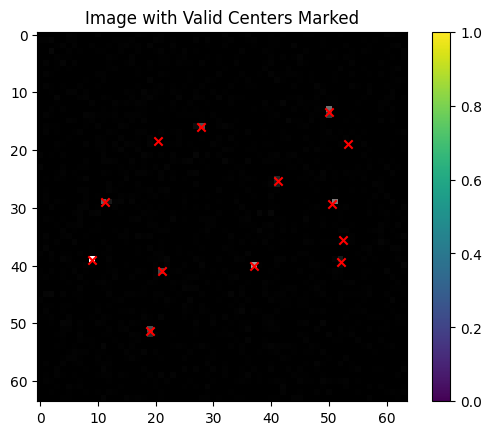

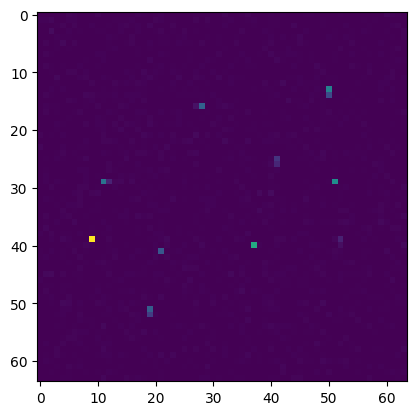

In [7]:
l=np.random.randint(0,len(centers))
data_loader.plot_image_with_centers(l)
plt.imshow(images[l])

In [8]:

# Normalize the data and split it into training and validation sets
train_images, val_images, train_midpoints, val_midpoints = data_loader.split_data()

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))


In [9]:

batch_size = 2500
train_dataset = train_dataset.shuffle(buffer_size=10000, reshuffle_each_iteration=True).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=10000).batch(batch_size)

# Check the shape of the datasets
print(f'Train Images: {train_images.shape}, Train Midpoints: {train_midpoints.shape}')
print(f'Validation Images: {val_images.shape}, Validation Midpoints: {val_midpoints.shape}')


Train Images: (800000, 64, 64), Train Midpoints: (800000, 1, 13, 2)
Validation Images: (200000, 64, 64), Validation Midpoints: (200000, 1, 13, 2)


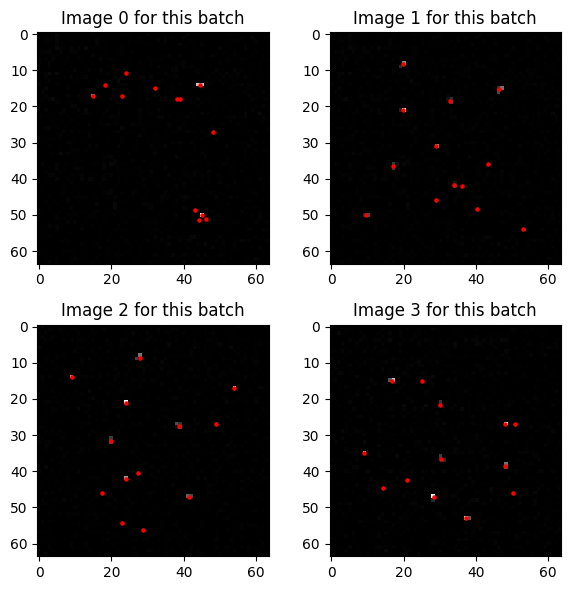

In [10]:
plot_transposed_images_with_midpoints(train_dataset, image_indices=[0, 1, 2, 3])

In [11]:


# Set up learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.9, patience=10, verbose=1, mode='min', min_lr=7e-8
)


In [12]:
# import tensorflow as tf
##### used this initially 
# class DynamicHuberLoss(tf.keras.losses.Loss):
#     def __init__(self, initial_delta, final_delta, total_epochs, **kwargs):
#         super().__init__(**kwargs)
#         self.initial_delta = initial_delta
#         self.final_delta = final_delta
#         self.total_epochs = total_epochs
#         self.current_epoch = 0

#     def call(self, y_true, y_pred):
#         # Compute current delta
#         delta = self.initial_delta - ((self.initial_delta - self.final_delta) * (self.current_epoch / self.total_epochs))
#         # Compute Huber loss with current delta
#         return tf.keras.losses.huber(y_true, y_pred, delta=delta)

#     def update_epoch(self, epoch):
#         self.current_epoch = epoch

class DynamicHuberLoss(tf.keras.losses.Loss):
    def __init__(self, initial_delta=1.0, final_delta=0.1, total_epochs=1000, **kwargs):
        super().__init__(**kwargs)
        self.initial_delta = initial_delta
        self.final_delta = final_delta
        self.total_epochs = total_epochs
        self.current_epoch = 0

    def call(self, y_true, y_pred):
        # Dynamically adjust delta based on the current epoch
        delta = self.initial_delta - ((self.initial_delta - self.final_delta) * (self.current_epoch / self.total_epochs))
        error = y_true - y_pred
        abs_error = tf.abs(error)
        quadratic = tf.minimum(abs_error, delta)
        linear = abs_error - quadratic
        loss = 0.5 * quadratic**2 + delta * linear
        return tf.reduce_mean(loss)

    def update_epoch(self, epoch):
        self.current_epoch = epoch

In [14]:
# Instantiate the dynamic Huber loss
dynamic_huber_loss = DynamicHuberLoss(initial_delta=1.0, final_delta=0.1, total_epochs=1000)



# Create a custom callback to update the epoch
class UpdateEpochCallback(tf.keras.callbacks.Callback):
    def __init__(self, loss_fn):
        super().__init__()
        self.loss_fn = loss_fn
        self.current_epoch = 0

    def on_epoch_begin(self, epoch, logs=None):
        self.loss_fn.update_epoch(epoch)

# Instantiate the callback
update_epoch_callback = UpdateEpochCallback(dynamic_huber_loss)



In [15]:

# Initialize the ModelBuilder within the strategy scope
with strategy.scope():
    # Instantiate the model builder
    model_builder = ModelBuilder()

    # Build the model
    model_builder.build_model()

    # Display the model architecture
    model_builder.model.summary()

    # Compile the model
    model_builder.compile_model(loss_function=dynamic_huber_loss)
    # model_builder.compile_model(loss_function=tf.keras.losses.MeanSquaredError())
    # If using a custom loss function, replace the above line with:
    # model_builder.compile_model(loss_function=custom_loss(exponent=2))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      1,184 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      2,080 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     23,168 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d[0][0],     │
│ (Concatenate)       │ 128)              │            │ conv2d_1[0][0],   │
│                     │                   │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 524288)    │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │ 33,554,496 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │        528 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x_midpoints (Dense) │ (None, 26)        │        442 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x_midpoints_reshape │ (None, 1, 13, 2)  │          0 │ x_midpoints[0][0] │
│ (Reshape)           │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,583,978 (128.11 MB)

 Trainable params: 33,583,978 (128.11 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:

# Train the model
history = model_builder.train_model(
    train_dataset, 
    val_dataset, 
    epochs=800,
    callbacks_list=[update_epoch_callback,lr_scheduler]
)


Epoch 1/800


2024-09-19 22:04:22.663285: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-09-19 22:04:25.837729: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1726783465.886435  854951 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726783465.909525  854951 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726783465.930864  854951 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726783465.939354  854951 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726783465.944529  854951 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726783465.966031  854951 gpu_timer.cc

  1/320 ━━━━━━━━━━━━━━━━━━━━ 37:31 7s/step - loss: 0.0329

W0000 00:00:1726783469.238135  854942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726783469.240100  854942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726783469.245187  854942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726783469.269757  854942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726783469.275125  854942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726783469.291616  854942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0205

2024-09-19 22:05:25.341287: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-09-19 22:05:25.341398: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-09-19 22:05:27.718102: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
W0000 00:00:1726783528.004793  854953 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726783528.010288  854945 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726783528.012280  854953 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced

320/320 ━━━━━━━━━━━━━━━━━━━━ 73s 206ms/step - loss: 0.0205 - val_loss: 0.0101 - learning_rate: 0.0100
Epoch 2/800


2024-09-19 22:05:35.053654: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0165

2024-09-19 22:06:43.434191: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 73s 200ms/step - loss: 0.0165 - val_loss: 0.0098 - learning_rate: 0.0100
Epoch 3/800


2024-09-19 22:06:47.781143: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0164

2024-09-19 22:07:53.756896: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 200ms/step - loss: 0.0164 - val_loss: 0.0102 - learning_rate: 0.0100
Epoch 4/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0164

2024-09-19 22:09:04.457036: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 71s 201ms/step - loss: 0.0164 - val_loss: 0.0098 - learning_rate: 0.0100
Epoch 5/800


2024-09-19 22:09:08.829815: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0163

2024-09-19 22:10:14.798673: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 200ms/step - loss: 0.0163 - val_loss: 0.0097 - learning_rate: 0.0100
Epoch 6/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0163

2024-09-19 22:11:25.151608: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 200ms/step - loss: 0.0163 - val_loss: 0.0097 - learning_rate: 0.0100
Epoch 7/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0163

2024-09-19 22:12:35.885096: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 71s 201ms/step - loss: 0.0162 - val_loss: 0.0096 - learning_rate: 0.0100
Epoch 8/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0162

2024-09-19 22:13:46.543671: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 71s 201ms/step - loss: 0.0162 - val_loss: 0.0096 - learning_rate: 0.0100
Epoch 9/800


2024-09-19 22:13:50.944685: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0162

2024-09-19 22:14:57.109400: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 71s 200ms/step - loss: 0.0162 - val_loss: 0.0096 - learning_rate: 0.0100
Epoch 10/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0162

2024-09-19 22:16:07.856587: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 71s 201ms/step - loss: 0.0162 - val_loss: 0.0104 - learning_rate: 0.0100
Epoch 11/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0164

2024-09-19 22:17:18.515569: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 71s 200ms/step - loss: 0.0164 - val_loss: 0.0097 - learning_rate: 0.0100
Epoch 12/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0163

2024-09-19 22:18:29.132195: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 71s 200ms/step - loss: 0.0162 - val_loss: 0.0096 - learning_rate: 0.0100
Epoch 13/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0163

2024-09-19 22:19:39.226824: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0163 - val_loss: 0.0096 - learning_rate: 0.0100
Epoch 14/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0162

2024-09-19 22:20:51.334337: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 72s 199ms/step - loss: 0.0162 - val_loss: 0.0096 - learning_rate: 0.0100
Epoch 15/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0162

2024-09-19 22:22:01.822990: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 200ms/step - loss: 0.0162 - val_loss: 0.0096 - learning_rate: 0.0100
Epoch 16/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0162

2024-09-19 22:23:11.963341: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0162 - val_loss: 0.0096 - learning_rate: 0.0100
Epoch 17/800


2024-09-19 22:23:16.355827: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0162

2024-09-19 22:24:22.191687: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0161 - val_loss: 0.0096 - learning_rate: 0.0100
Epoch 18/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0162

2024-09-19 22:25:32.315119: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0161 - val_loss: 0.0096 - learning_rate: 0.0100
Epoch 19/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0162

2024-09-19 22:26:42.631636: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 19: ReduceLROnPlateau reducing learning rate to 0.008999999798834325.
320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0162 - val_loss: 0.0096 - learning_rate: 0.0100
Epoch 20/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0161

2024-09-19 22:27:52.596010: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0161 - val_loss: 0.0096 - learning_rate: 0.0090
Epoch 21/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0161

2024-09-19 22:29:02.346358: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0161 - val_loss: 0.0096 - learning_rate: 0.0090
Epoch 22/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0163

2024-09-19 22:30:12.401589: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0162 - val_loss: 0.0097 - learning_rate: 0.0090
Epoch 23/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0162

2024-09-19 22:31:22.364045: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0162 - val_loss: 0.0096 - learning_rate: 0.0090
Epoch 24/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0162

2024-09-19 22:32:32.511151: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0162 - val_loss: 0.0096 - learning_rate: 0.0090
Epoch 25/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0161

2024-09-19 22:33:42.349529: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 194ms/step - loss: 0.0161 - val_loss: 0.0096 - learning_rate: 0.0090
Epoch 26/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0162

2024-09-19 22:34:52.403022: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0162 - val_loss: 0.0096 - learning_rate: 0.0090
Epoch 27/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0161

2024-09-19 22:36:02.619607: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0161 - val_loss: 0.0096 - learning_rate: 0.0090
Epoch 28/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0162

2024-09-19 22:37:12.703070: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0162 - val_loss: 0.0096 - learning_rate: 0.0090
Epoch 29/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0161

2024-09-19 22:38:22.714790: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 29: ReduceLROnPlateau reducing learning rate to 0.008099999651312828.
320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0161 - val_loss: 0.0096 - learning_rate: 0.0090
Epoch 30/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0161

2024-09-19 22:39:34.459771: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 72s 198ms/step - loss: 0.0161 - val_loss: 0.0096 - learning_rate: 0.0081
Epoch 31/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0161

2024-09-19 22:40:44.429453: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0161 - val_loss: 0.0096 - learning_rate: 0.0081
Epoch 32/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0161

2024-09-19 22:41:54.560449: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0161 - val_loss: 0.0096 - learning_rate: 0.0081
Epoch 33/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0162

2024-09-19 22:43:02.470386: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-09-19 22:43:04.800364: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0161 - val_loss: 0.0096 - learning_rate: 0.0081
Epoch 34/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0161

2024-09-19 22:44:14.935711: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0161 - val_loss: 0.0097 - learning_rate: 0.0081
Epoch 35/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0161

2024-09-19 22:45:24.959942: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0161 - val_loss: 0.0097 - learning_rate: 0.0081
Epoch 36/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0161

2024-09-19 22:46:34.846024: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0161 - val_loss: 0.0097 - learning_rate: 0.0081
Epoch 37/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0161

2024-09-19 22:47:44.880717: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0161 - val_loss: 0.0097 - learning_rate: 0.0081
Epoch 38/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0161

2024-09-19 22:48:54.886356: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0161 - val_loss: 0.0098 - learning_rate: 0.0081
Epoch 39/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0161

2024-09-19 22:50:05.073107: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 39: ReduceLROnPlateau reducing learning rate to 0.007289999350905419.
320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0161 - val_loss: 0.0097 - learning_rate: 0.0081
Epoch 40/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0161

2024-09-19 22:51:15.024198: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0161 - val_loss: 0.0097 - learning_rate: 0.0073
Epoch 41/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0161

2024-09-19 22:52:25.110805: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0161 - val_loss: 0.0097 - learning_rate: 0.0073
Epoch 42/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0161

2024-09-19 22:53:35.009331: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0161 - val_loss: 0.0097 - learning_rate: 0.0073
Epoch 43/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0161

2024-09-19 22:54:44.970678: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0161 - val_loss: 0.0097 - learning_rate: 0.0073
Epoch 44/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0161

2024-09-19 22:55:54.941424: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0161 - val_loss: 0.0097 - learning_rate: 0.0073
Epoch 45/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0161

2024-09-19 22:57:04.735364: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0161 - val_loss: 0.0097 - learning_rate: 0.0073
Epoch 46/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0161

2024-09-19 22:58:14.661641: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0161 - val_loss: 0.0097 - learning_rate: 0.0073
Epoch 47/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0161

2024-09-19 22:59:24.630230: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0161 - val_loss: 0.0098 - learning_rate: 0.0073
Epoch 48/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0161

2024-09-19 23:00:34.637166: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0161 - val_loss: 0.0097 - learning_rate: 0.0073
Epoch 49/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0161

2024-09-19 23:01:43.950610: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 49: ReduceLROnPlateau reducing learning rate to 0.006560999248176813.
320/320 ━━━━━━━━━━━━━━━━━━━━ 69s 198ms/step - loss: 0.0160 - val_loss: 0.0097 - learning_rate: 0.0073
Epoch 50/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0161

2024-09-19 23:02:52.973023: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 69s 195ms/step - loss: 0.0161 - val_loss: 0.0097 - learning_rate: 0.0066
Epoch 51/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0161

2024-09-19 23:03:59.593842: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 67s 192ms/step - loss: 0.0161 - val_loss: 0.0097 - learning_rate: 0.0066
Epoch 52/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0161

2024-09-19 23:05:05.719582: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 198ms/step - loss: 0.0160 - val_loss: 0.0097 - learning_rate: 0.0066
Epoch 53/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0160

2024-09-19 23:06:14.061577: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0160 - val_loss: 0.0097 - learning_rate: 0.0066
Epoch 54/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0161

2024-09-19 23:07:18.259570: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0160 - val_loss: 0.0097 - learning_rate: 0.0066
Epoch 55/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0161

2024-09-19 23:08:28.606156: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0161 - val_loss: 0.0097 - learning_rate: 0.0066
Epoch 56/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0161

2024-09-19 23:09:38.786430: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0160 - val_loss: 0.0097 - learning_rate: 0.0066
Epoch 57/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0161

2024-09-19 23:10:48.600305: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0161 - val_loss: 0.0097 - learning_rate: 0.0066
Epoch 58/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0161

2024-09-19 23:11:58.528604: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0160 - val_loss: 0.0097 - learning_rate: 0.0066
Epoch 59/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-19 23:13:08.649530: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 59: ReduceLROnPlateau reducing learning rate to 0.005904899490997195.
320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0160 - val_loss: 0.0097 - learning_rate: 0.0066
Epoch 60/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0161

2024-09-19 23:14:18.779513: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0059
Epoch 61/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0161

2024-09-19 23:15:29.064883: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0161 - val_loss: 0.0098 - learning_rate: 0.0059
Epoch 62/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0161

2024-09-19 23:16:37.141312: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0059
Epoch 63/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-19 23:17:41.334691: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0059
Epoch 64/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0160

2024-09-19 23:18:51.138631: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0059
Epoch 65/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0161

2024-09-19 23:20:01.083299: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0161 - val_loss: 0.0098 - learning_rate: 0.0059
Epoch 66/800


2024-09-19 23:20:05.484798: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-19 23:21:11.341371: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0059
Epoch 67/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-19 23:22:21.441023: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0059
Epoch 68/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-19 23:23:31.471635: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0059
Epoch 69/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-19 23:24:39.527830: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 69: ReduceLROnPlateau reducing learning rate to 0.00531440949998796.
320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0059
Epoch 70/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0161

2024-09-19 23:25:43.725968: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0053
Epoch 71/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0160

2024-09-19 23:26:53.601549: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0053
Epoch 72/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-19 23:28:03.193484: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0053
Epoch 73/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-19 23:29:13.234133: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0053
Epoch 74/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0161

2024-09-19 23:30:23.346745: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0053
Epoch 75/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-19 23:31:33.409286: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0053
Epoch 76/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0161

2024-09-19 23:32:41.596947: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0053
Epoch 77/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-19 23:33:45.710428: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 192ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0053
Epoch 78/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-19 23:34:55.633417: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0053
Epoch 79/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-19 23:36:05.885642: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 79: ReduceLROnPlateau reducing learning rate to 0.004782968759536744.
320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0053
Epoch 80/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0160

2024-09-19 23:37:17.730049: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 72s 198ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0048
Epoch 81/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-19 23:38:25.346646: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 196ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0048
Epoch 82/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0160

2024-09-19 23:39:34.179690: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 69s 192ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0048
Epoch 83/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-19 23:40:40.116273: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0048
Epoch 84/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0160

2024-09-19 23:41:48.254541: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 198ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0048
Epoch 85/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-19 23:42:58.487251: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0048
Epoch 86/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-19 23:44:06.506354: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0048
Epoch 87/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0160

2024-09-19 23:45:10.437796: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0048
Epoch 88/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-19 23:46:20.594858: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0048
Epoch 89/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-19 23:47:30.719618: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 89: ReduceLROnPlateau reducing learning rate to 0.0043046717997640375.
320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0048
Epoch 90/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-19 23:48:41.036269: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0043
Epoch 91/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0160

2024-09-19 23:49:50.960832: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0159 - val_loss: 0.0098 - learning_rate: 0.0043
Epoch 92/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-19 23:50:59.255736: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0043
Epoch 93/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-19 23:52:09.309194: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 192ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0043
Epoch 94/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-19 23:53:16.332898: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 67s 193ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0043
Epoch 95/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-19 23:54:26.399479: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 193ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0043
Epoch 96/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-19 23:55:30.351237: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0043
Epoch 97/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-19 23:56:38.547723: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0043
Epoch 98/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-19 23:57:42.737043: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0043
Epoch 99/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-19 23:58:52.889380: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 99: ReduceLROnPlateau reducing learning rate to 0.0038742044940590858.
320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0043
Epoch 100/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-19 23:59:57.491512: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0039
Epoch 101/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:01:09.408230: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 72s 199ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0039
Epoch 102/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:02:17.697306: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0039
Epoch 103/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:03:21.719486: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0159 - val_loss: 0.0098 - learning_rate: 0.0039
Epoch 104/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:04:29.686955: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0039
Epoch 105/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:05:33.894213: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0159 - val_loss: 0.0098 - learning_rate: 0.0039
Epoch 106/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0160

2024-09-20 00:06:43.679515: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0160 - val_loss: 0.0099 - learning_rate: 0.0039
Epoch 107/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:07:51.827923: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0039
Epoch 108/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:08:55.862970: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0039
Epoch 109/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:10:03.868567: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 109: ReduceLROnPlateau reducing learning rate to 0.003486784128472209.
320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0159 - val_loss: 0.0098 - learning_rate: 0.0039
Epoch 110/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:11:09.735253: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 192ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0035
Epoch 111/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:12:18.253686: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 199ms/step - loss: 0.0160 - val_loss: 0.0098 - learning_rate: 0.0035
Epoch 112/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:13:28.369946: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0160 - val_loss: 0.0099 - learning_rate: 0.0035
Epoch 113/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:14:36.520833: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0159 - val_loss: 0.0099 - learning_rate: 0.0035
Epoch 114/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:15:40.589686: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0160 - val_loss: 0.0099 - learning_rate: 0.0035
Epoch 115/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:16:51.257965: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 71s 201ms/step - loss: 0.0160 - val_loss: 0.0099 - learning_rate: 0.0035
Epoch 116/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:17:59.456572: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0160 - val_loss: 0.0099 - learning_rate: 0.0035
Epoch 117/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0160

2024-09-20 00:19:03.451234: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0160 - val_loss: 0.0099 - learning_rate: 0.0035
Epoch 118/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:20:13.865396: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 200ms/step - loss: 0.0159 - val_loss: 0.0099 - learning_rate: 0.0035
Epoch 119/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:21:23.881666: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 119: ReduceLROnPlateau reducing learning rate to 0.003138105757534504.
320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0159 - val_loss: 0.0099 - learning_rate: 0.0035
Epoch 120/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:22:31.836425: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0160 - val_loss: 0.0099 - learning_rate: 0.0031
Epoch 121/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0160

2024-09-20 00:23:35.665168: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0160 - val_loss: 0.0099 - learning_rate: 0.0031
Epoch 122/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:24:45.741685: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0159 - val_loss: 0.0099 - learning_rate: 0.0031
Epoch 123/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:25:53.833645: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0160 - val_loss: 0.0099 - learning_rate: 0.0031
Epoch 124/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 00:26:57.827046: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0159 - val_loss: 0.0099 - learning_rate: 0.0031
Epoch 125/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:28:08.061648: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0160 - val_loss: 0.0099 - learning_rate: 0.0031
Epoch 126/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:29:18.173051: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0159 - val_loss: 0.0099 - learning_rate: 0.0031
Epoch 127/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:30:26.198495: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0160 - val_loss: 0.0099 - learning_rate: 0.0031
Epoch 128/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:31:30.803968: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 201ms/step - loss: 0.0160 - val_loss: 0.0099 - learning_rate: 0.0031
Epoch 129/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:32:44.668480: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 129: ReduceLROnPlateau reducing learning rate to 0.0028242952656000854.
320/320 ━━━━━━━━━━━━━━━━━━━━ 74s 210ms/step - loss: 0.0160 - val_loss: 0.0099 - learning_rate: 0.0031
Epoch 130/800


2024-09-20 00:32:49.052728: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0160

2024-09-20 00:33:52.754785: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0160 - val_loss: 0.0099 - learning_rate: 0.0028
Epoch 131/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:35:09.480182: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 77s 211ms/step - loss: 0.0160 - val_loss: 0.0099 - learning_rate: 0.0028
Epoch 132/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 00:36:17.351630: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0159 - val_loss: 0.0099 - learning_rate: 0.0028
Epoch 133/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 00:37:21.806740: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 200ms/step - loss: 0.0159 - val_loss: 0.0099 - learning_rate: 0.0028
Epoch 134/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0160

2024-09-20 00:38:31.944802: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0159 - val_loss: 0.0099 - learning_rate: 0.0028
Epoch 135/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 00:39:40.049122: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0159 - val_loss: 0.0099 - learning_rate: 0.0028
Epoch 136/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0160

2024-09-20 00:40:44.019811: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0159 - val_loss: 0.0099 - learning_rate: 0.0028
Epoch 137/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:41:52.088925: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0160 - val_loss: 0.0099 - learning_rate: 0.0028
Epoch 138/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:42:56.334351: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 194ms/step - loss: 0.0160 - val_loss: 0.0099 - learning_rate: 0.0028
Epoch 139/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0160

2024-09-20 00:44:06.334816: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 139: ReduceLROnPlateau reducing learning rate to 0.0025418657809495927.
320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0160 - val_loss: 0.0099 - learning_rate: 0.0028
Epoch 140/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 00:45:16.401085: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0159 - val_loss: 0.0099 - learning_rate: 0.0025
Epoch 141/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:46:24.535506: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0160 - val_loss: 0.0100 - learning_rate: 0.0025
Epoch 142/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:47:28.671105: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0160 - val_loss: 0.0099 - learning_rate: 0.0025
Epoch 143/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 00:48:38.905601: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0025
Epoch 144/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0159

2024-09-20 00:49:41.633693: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 194ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0025
Epoch 145/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 00:50:51.459928: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0025
Epoch 146/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:52:01.529704: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0160 - val_loss: 0.0100 - learning_rate: 0.0025
Epoch 147/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 00:53:09.731786: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0025
Epoch 148/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:54:13.729067: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0025
Epoch 149/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 00:55:21.818772: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 149: ReduceLROnPlateau reducing learning rate to 0.0022876791190356016.
320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0025
Epoch 150/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 00:56:28.416496: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 67s 192ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0023
Epoch 151/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 00:57:35.906359: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 199ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0023
Epoch 152/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 00:58:46.052264: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0160 - val_loss: 0.0100 - learning_rate: 0.0023
Epoch 153/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 00:59:54.781440: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 69s 194ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0023
Epoch 154/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 01:01:03.628026: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 69s 192ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0023
Epoch 155/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0160

2024-09-20 01:02:08.109023: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 198ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0023
Epoch 156/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0160

2024-09-20 01:03:18.103931: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0160 - val_loss: 0.0100 - learning_rate: 0.0023
Epoch 157/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 01:04:28.232460: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0023
Epoch 158/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 01:05:36.185931: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0160 - val_loss: 0.0100 - learning_rate: 0.0023
Epoch 159/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 01:06:43.863798: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 159: ReduceLROnPlateau reducing learning rate to 0.0020589112071320416.
320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0023
Epoch 160/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 01:07:50.555642: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 67s 194ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0021
Epoch 161/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 01:09:00.545640: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0021
Epoch 162/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 01:10:10.751504: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0021
Epoch 163/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 01:11:20.980133: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0021
Epoch 164/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 01:12:31.119899: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0021
Epoch 165/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 01:13:38.759507: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 199ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0021
Epoch 166/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0160

2024-09-20 01:14:48.584019: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0160 - val_loss: 0.0100 - learning_rate: 0.0021
Epoch 167/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 01:15:58.561385: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0021
Epoch 168/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 01:17:09.863411: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 71s 203ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0021
Epoch 169/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 01:18:18.364582: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 169: ReduceLROnPlateau reducing learning rate to 0.0018530200235545636.
320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 194ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0021
Epoch 170/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 01:19:23.160844: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 194ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0019
Epoch 171/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 01:20:33.117985: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 201ms/step - loss: 0.0158 - val_loss: 0.0100 - learning_rate: 0.0019
Epoch 172/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 01:21:43.171847: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0019
Epoch 173/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 01:22:53.286621: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0019
Epoch 174/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 01:24:01.378798: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0159 - val_loss: 0.0099 - learning_rate: 0.0019
Epoch 175/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 01:25:06.148625: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 201ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0019
Epoch 176/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 01:26:16.214117: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0019
Epoch 177/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 01:27:27.416719: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 71s 202ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0019
Epoch 178/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 01:28:37.640110: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0019
Epoch 179/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 01:29:45.715587: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 179: ReduceLROnPlateau reducing learning rate to 0.0016677180421538651.
320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0019
Epoch 180/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 01:30:49.832862: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 197ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0017
Epoch 181/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 01:31:59.972537: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0017
Epoch 182/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 01:33:08.125378: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0017
Epoch 183/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0160

2024-09-20 01:34:12.100031: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 192ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0017
Epoch 184/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 01:35:22.065035: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0017
Epoch 185/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 01:36:32.224188: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0017
Epoch 186/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 01:37:39.997503: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0017
Epoch 187/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0160

2024-09-20 01:38:46.350523: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 192ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0017
Epoch 188/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 01:39:54.017489: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 198ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0017
Epoch 189/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 01:41:04.226814: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 189: ReduceLROnPlateau reducing learning rate to 0.0015009462484158575.
320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0017
Epoch 190/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 01:42:14.194799: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0015
Epoch 191/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 01:43:22.224621: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0015
Epoch 192/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 01:44:26.004181: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0015
Epoch 193/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 01:45:34.099563: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0015
Epoch 194/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 01:46:38.019325: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0158 - val_loss: 0.0100 - learning_rate: 0.0015
Epoch 195/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 01:47:47.975035: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0015
Epoch 196/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 01:48:55.978740: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0015
Epoch 197/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 01:50:00.082651: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 196ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0015
Epoch 198/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 01:51:10.183364: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0015
Epoch 199/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 01:52:18.066931: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 199: ReduceLROnPlateau reducing learning rate to 0.0013508516130968928.
320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0158 - val_loss: 0.0100 - learning_rate: 0.0015
Epoch 200/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 01:53:21.940617: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0014
Epoch 201/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 01:54:30.004835: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0014
Epoch 202/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 01:55:34.835174: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 192ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0014
Epoch 203/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 01:56:44.555820: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0014
Epoch 204/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 01:57:54.953011: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0014
Epoch 205/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 01:59:03.074126: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0014
Epoch 206/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 02:00:07.023292: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0014
Epoch 207/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 02:01:16.895659: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0014
Epoch 208/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 02:02:24.627878: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0014
Epoch 209/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 02:03:28.505871: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 209: ReduceLROnPlateau reducing learning rate to 0.0012157664517872036.
320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0014
Epoch 210/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 02:04:36.548114: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0012
Epoch 211/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 02:05:40.532683: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 196ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0012
Epoch 212/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 02:06:50.899473: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0012
Epoch 213/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 02:08:01.233850: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0012
Epoch 214/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 02:09:09.445919: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0012
Epoch 215/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 02:10:13.895674: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 192ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0012
Epoch 216/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 02:11:23.360127: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0012
Epoch 217/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 02:12:31.291076: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0012
Epoch 218/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 02:13:36.464017: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 192ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0012
Epoch 219/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 02:14:45.466539: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 219: ReduceLROnPlateau reducing learning rate to 0.0010941897751763463.
320/320 ━━━━━━━━━━━━━━━━━━━━ 69s 199ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0012
Epoch 220/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 02:15:53.339084: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 191ms/step - loss: 0.0158 - val_loss: 0.0100 - learning_rate: 0.0011
Epoch 221/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 02:16:58.569087: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0011
Epoch 222/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 02:18:07.534452: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 69s 198ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0011
Epoch 223/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 02:19:15.373203: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0158 - val_loss: 0.0100 - learning_rate: 0.0011
Epoch 224/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 02:20:19.530027: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0011
Epoch 225/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 02:21:27.639574: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 0.0011
Epoch 226/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 02:22:31.826661: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 0.0011
Epoch 227/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 02:23:39.716709: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0158 - val_loss: 0.0100 - learning_rate: 0.0011
Epoch 228/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0158

2024-09-20 02:24:44.096777: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 200ms/step - loss: 0.0158 - val_loss: 0.0100 - learning_rate: 0.0011
Epoch 229/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 02:25:52.346140: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 229: ReduceLROnPlateau reducing learning rate to 0.0009847708395682275.
320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0100 - learning_rate: 0.0011
Epoch 230/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 02:26:56.450489: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0100 - learning_rate: 9.8477e-04
Epoch 231/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 02:28:06.688818: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 200ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 9.8477e-04
Epoch 232/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 02:29:14.860386: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 9.8477e-04
Epoch 233/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0158

2024-09-20 02:30:18.794061: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 195ms/step - loss: 0.0158 - val_loss: 0.0100 - learning_rate: 9.8477e-04
Epoch 234/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 02:31:26.844756: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0158 - val_loss: 0.0100 - learning_rate: 9.8477e-04
Epoch 235/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 02:32:33.010784: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 9.8477e-04
Epoch 236/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 02:33:40.995334: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 198ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 9.8477e-04
Epoch 237/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 02:34:49.080415: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 9.8477e-04
Epoch 238/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0158

2024-09-20 02:35:58.792227: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 194ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 9.8477e-04
Epoch 239/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 02:37:03.445446: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 239: ReduceLROnPlateau reducing learning rate to 0.0008862937451340258.
320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 195ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 9.8477e-04
Epoch 240/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 02:38:13.428347: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 8.8629e-04
Epoch 241/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 02:39:23.301722: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 194ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 8.8629e-04
Epoch 242/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 02:40:33.149090: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 8.8629e-04
Epoch 243/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 02:41:41.144014: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 8.8629e-04
Epoch 244/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 02:42:44.903818: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 194ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 8.8629e-04
Epoch 245/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 02:43:54.793683: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 8.8629e-04
Epoch 246/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 02:45:02.660801: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 8.8629e-04
Epoch 247/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0158

2024-09-20 02:46:06.560764: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 8.8629e-04
Epoch 248/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 02:47:14.478530: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 8.8629e-04
Epoch 249/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 02:48:18.504643: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 249: ReduceLROnPlateau reducing learning rate to 0.0007976643915753812.
320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 194ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 8.8629e-04
Epoch 250/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 02:49:28.325964: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 7.9766e-04
Epoch 251/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 02:50:36.263539: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 7.9766e-04
Epoch 252/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 02:51:40.512231: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 192ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 7.9766e-04
Epoch 253/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 02:52:48.707469: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 7.9766e-04
Epoch 254/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 02:53:56.081265: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 67s 193ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 7.9766e-04
Epoch 255/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 02:55:02.829509: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 67s 198ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 7.9766e-04
Epoch 256/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 02:56:10.616624: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 7.9766e-04
Epoch 257/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 02:57:14.585703: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 7.9766e-04
Epoch 258/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 02:58:21.693788: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 67s 192ms/step - loss: 0.0159 - val_loss: 0.0100 - learning_rate: 7.9766e-04
Epoch 259/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 02:59:26.224931: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 259: ReduceLROnPlateau reducing learning rate to 0.0007178979576565325.
320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 7.9766e-04
Epoch 260/800


2024-09-20 02:59:30.640623: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 03:00:34.259793: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 7.1790e-04
Epoch 261/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 03:01:38.321850: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 7.1790e-04
Epoch 262/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 03:02:46.385981: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 7.1790e-04
Epoch 263/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 03:03:50.521521: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 194ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 7.1790e-04
Epoch 264/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0158

2024-09-20 03:05:00.246655: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 197ms/step - loss: 0.0158 - val_loss: 0.0100 - learning_rate: 7.1790e-04
Epoch 265/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 03:06:10.263443: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 7.1790e-04
Epoch 266/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 03:07:18.017861: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 191ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 7.1790e-04
Epoch 267/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0158

2024-09-20 03:08:19.793703: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 192ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 7.1790e-04
Epoch 268/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 03:09:24.026886: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 192ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 7.1790e-04
Epoch 269/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 03:10:31.536569: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 269: ReduceLROnPlateau reducing learning rate to 0.0006461081618908793.
320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 7.1790e-04
Epoch 270/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 03:11:35.502848: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 6.4611e-04
Epoch 271/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 03:12:43.419397: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 6.4611e-04
Epoch 272/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 03:13:47.289422: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 195ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 6.4611e-04
Epoch 273/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 03:14:57.441552: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 6.4611e-04
Epoch 274/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 03:16:05.584790: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 6.4611e-04
Epoch 275/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 03:17:09.464575: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 6.4611e-04
Epoch 276/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 03:18:17.599576: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 6.4611e-04
Epoch 277/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 03:19:21.646498: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 6.4611e-04
Epoch 278/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 03:20:30.163941: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 69s 194ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 6.4611e-04
Epoch 279/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 03:21:38.017632: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 279: ReduceLROnPlateau reducing learning rate to 0.0005814973614178598.
320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 6.4611e-04
Epoch 280/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 03:22:44.522185: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 199ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 5.8150e-04
Epoch 281/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 03:23:52.719618: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 5.8150e-04
Epoch 282/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0158

2024-09-20 03:24:56.725912: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 5.8150e-04
Epoch 283/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 03:26:04.820243: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 5.8150e-04
Epoch 284/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 03:27:08.887552: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 5.8150e-04
Epoch 285/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 03:28:17.003886: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 5.8150e-04
Epoch 286/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0158

2024-09-20 03:29:20.930006: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 5.8150e-04
Epoch 287/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 03:30:29.077159: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 5.8150e-04
Epoch 288/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 03:31:30.960762: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 192ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 5.8150e-04
Epoch 289/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 03:32:34.939221: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 289: ReduceLROnPlateau reducing learning rate to 0.0005233476462308317.
320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 5.8150e-04
Epoch 290/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 03:33:43.088285: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 5.2335e-04
Epoch 291/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 03:34:53.250395: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 192ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 5.2335e-04
Epoch 292/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 03:35:57.094036: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 196ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 5.2335e-04
Epoch 293/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 03:37:05.190288: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 5.2335e-04
Epoch 294/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 03:38:09.266985: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 5.2335e-04
Epoch 295/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 03:39:19.032377: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 5.2335e-04
Epoch 296/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 03:40:27.234664: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 5.2335e-04
Epoch 297/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0158

2024-09-20 03:41:31.186921: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 195ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 5.2335e-04
Epoch 298/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 03:42:39.291346: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 5.2335e-04
Epoch 299/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0158

2024-09-20 03:43:46.234634: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 299: ReduceLROnPlateau reducing learning rate to 0.0004710128763690591.
320/320 ━━━━━━━━━━━━━━━━━━━━ 67s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 5.2335e-04
Epoch 300/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 03:44:53.609590: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 67s 198ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 4.7101e-04
Epoch 301/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 03:46:03.735293: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 4.7101e-04
Epoch 302/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 03:47:11.739027: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 4.7101e-04
Epoch 303/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0158

2024-09-20 03:48:15.421777: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 197ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 4.7101e-04
Epoch 304/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 03:49:23.464985: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 4.7101e-04
Epoch 305/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 03:50:27.392382: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 195ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 4.7101e-04
Epoch 306/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0158

2024-09-20 03:51:37.266355: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 4.7101e-04
Epoch 307/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0158

2024-09-20 03:52:45.173837: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 4.7101e-04
Epoch 308/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 03:53:49.281490: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 196ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 4.7101e-04
Epoch 309/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 03:54:58.606093: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 309: ReduceLROnPlateau reducing learning rate to 0.0004239115834934637.
320/320 ━━━━━━━━━━━━━━━━━━━━ 69s 198ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 4.7101e-04
Epoch 310/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 03:56:08.564773: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 4.2391e-04
Epoch 311/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 03:57:16.179790: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 191ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 4.2391e-04
Epoch 312/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 03:58:18.114532: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 192ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 4.2391e-04
Epoch 313/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 03:59:22.209516: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 4.2391e-04
Epoch 314/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 04:00:30.144517: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 4.2391e-04
Epoch 315/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 04:01:34.183406: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 4.2391e-04
Epoch 316/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 04:02:44.398249: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 4.2391e-04
Epoch 317/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 04:03:52.312063: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 4.2391e-04
Epoch 318/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0159

2024-09-20 04:04:56.125968: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 197ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 4.2391e-04
Epoch 319/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 04:06:04.161265: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 319: ReduceLROnPlateau reducing learning rate to 0.0003815204225247726.
320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 4.2391e-04
Epoch 320/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0158

2024-09-20 04:07:07.832860: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 194ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 3.8152e-04
Epoch 321/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 04:08:15.805157: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 3.8152e-04
Epoch 322/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0158

2024-09-20 04:09:19.814708: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 197ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 3.8152e-04
Epoch 323/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 04:10:27.894501: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 3.8152e-04
Epoch 324/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 04:11:32.184523: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 195ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 3.8152e-04
Epoch 325/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0158

2024-09-20 04:12:41.193734: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 69s 195ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 3.8152e-04
Epoch 326/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 04:13:50.019100: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 69s 191ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 3.8152e-04
Epoch 327/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 04:14:54.513151: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 200ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 3.8152e-04
Epoch 328/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 04:16:02.619180: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 3.8152e-04
Epoch 329/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 04:17:08.075450: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 329: ReduceLROnPlateau reducing learning rate to 0.0003433683828916401.
320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 202ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 3.8152e-04
Epoch 330/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 04:18:26.528526: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 78s 192ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 3.4337e-04
Epoch 331/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 04:19:30.952447: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 197ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 3.4337e-04
Epoch 332/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 04:20:40.689474: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 3.4337e-04
Epoch 333/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 04:21:47.974838: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 67s 193ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 3.4337e-04
Epoch 334/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0159

2024-09-20 04:22:58.513491: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 71s 201ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 3.4337e-04
Epoch 335/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 04:24:06.871105: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 3.4337e-04
Epoch 336/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 04:25:11.025064: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 195ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 3.4337e-04
Epoch 337/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 04:26:19.180091: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 3.4337e-04
Epoch 338/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 04:27:23.330071: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 196ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 3.4337e-04
Epoch 339/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 04:28:31.608042: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 339: ReduceLROnPlateau reducing learning rate to 0.0003090315498411656.
320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 3.4337e-04
Epoch 340/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 04:29:35.832680: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 3.0903e-04
Epoch 341/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 04:30:44.312642: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 69s 193ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 3.0903e-04
Epoch 342/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 04:31:51.439191: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 67s 192ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 3.0903e-04
Epoch 343/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0159

2024-09-20 04:32:56.962013: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 3.0903e-04
Epoch 344/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 04:34:01.231995: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 3.0903e-04
Epoch 345/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0159

2024-09-20 04:35:09.687848: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 194ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 3.0903e-04
Epoch 346/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 04:36:13.904140: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 195ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 3.0903e-04
Epoch 347/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 04:37:22.045683: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 3.0903e-04
Epoch 348/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 04:38:26.131024: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 3.0903e-04
Epoch 349/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 04:39:34.191158: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 349: ReduceLROnPlateau reducing learning rate to 0.00027812838961835954.
320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 3.0903e-04
Epoch 350/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 04:40:38.782724: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 198ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.7813e-04
Epoch 351/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 04:41:46.995637: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.7813e-04
Epoch 352/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0159

2024-09-20 04:42:57.384767: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.7813e-04
Epoch 353/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 04:44:01.507621: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.7813e-04
Epoch 354/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 04:45:09.888320: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.7813e-04
Epoch 355/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 04:46:13.932367: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 195ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.7813e-04
Epoch 356/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 04:47:22.141670: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.7813e-04
Epoch 357/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 04:48:26.249891: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.7813e-04
Epoch 358/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 04:49:36.399733: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.7813e-04
Epoch 359/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 04:50:44.561464: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 359: ReduceLROnPlateau reducing learning rate to 0.00025031555851455777.
320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.7813e-04
Epoch 360/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 04:51:48.629247: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.5032e-04
Epoch 361/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0159

2024-09-20 04:52:56.976825: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.5032e-04
Epoch 362/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 04:54:01.204759: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 196ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.5032e-04
Epoch 363/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0158

2024-09-20 04:55:09.641322: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.5032e-04
Epoch 364/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 04:56:13.744951: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 2.5032e-04
Epoch 365/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 04:57:17.874432: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 192ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 2.5032e-04
Epoch 366/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0159

2024-09-20 04:58:24.169630: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.5032e-04
Epoch 367/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 04:59:28.360796: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.5032e-04
Epoch 368/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 05:00:36.483770: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.5032e-04
Epoch 369/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 05:01:40.721105: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 369: ReduceLROnPlateau reducing learning rate to 0.00022528400004375725.
320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.5032e-04
Epoch 370/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 05:02:48.771570: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.2528e-04
Epoch 371/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0158

2024-09-20 05:03:53.171679: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 200ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.2528e-04
Epoch 372/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 05:05:01.363494: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.2528e-04
Epoch 373/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 05:06:05.575591: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.2528e-04
Epoch 374/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0159

2024-09-20 05:07:13.911493: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 2.2528e-04
Epoch 375/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 05:08:18.044466: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 197ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.2528e-04
Epoch 376/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 05:09:26.377511: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.2528e-04
Epoch 377/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 05:10:30.460145: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.2528e-04
Epoch 378/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 05:11:38.745956: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.2528e-04
Epoch 379/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 05:12:42.003564: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 379: ReduceLROnPlateau reducing learning rate to 0.000202755605278071.
320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 196ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.2528e-04
Epoch 380/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 05:13:44.831272: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 195ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.0276e-04
Epoch 381/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 05:14:53.093605: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.0276e-04
Epoch 382/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 05:15:57.141991: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.0276e-04
Epoch 383/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0158

2024-09-20 05:17:05.008004: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.0276e-04
Epoch 384/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 05:18:07.168688: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.0276e-04
Epoch 385/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0158

2024-09-20 05:19:11.100464: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 194ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.0276e-04
Epoch 386/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 05:20:19.680175: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 69s 194ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 2.0276e-04
Epoch 387/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 05:21:23.775656: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.0276e-04
Epoch 388/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 05:22:31.935814: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.0276e-04
Epoch 389/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 05:23:35.979772: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 389: ReduceLROnPlateau reducing learning rate to 0.00018248004344059154.
320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.0276e-04
Epoch 390/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 05:24:44.274247: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.8248e-04
Epoch 391/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 05:25:48.302020: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 1.8248e-04
Epoch 392/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 05:26:55.420375: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 67s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.8248e-04
Epoch 393/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 05:27:58.546605: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 1.8248e-04
Epoch 394/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 05:29:02.671107: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.8248e-04
Epoch 395/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 05:30:10.620240: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 1.8248e-04
Epoch 396/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 05:31:12.869508: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.8248e-04
Epoch 397/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 05:32:16.993641: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 1.8248e-04
Epoch 398/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 05:33:25.235187: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.8248e-04
Epoch 399/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 05:34:29.317968: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 399: ReduceLROnPlateau reducing learning rate to 0.00016423203778686004.
320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.8248e-04
Epoch 400/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0159

2024-09-20 05:35:37.649398: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 1.6423e-04
Epoch 401/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 05:36:41.713871: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 1.6423e-04
Epoch 402/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 05:37:49.931840: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.6423e-04
Epoch 403/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0158

2024-09-20 05:38:53.949093: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 1.6423e-04
Epoch 404/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 05:40:02.048226: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.6423e-04
Epoch 405/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 05:41:06.139671: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 1.6423e-04
Epoch 406/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 05:42:14.194948: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.6423e-04
Epoch 407/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 05:43:16.324828: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 1.6423e-04
Epoch 408/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 05:44:20.423028: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 1.6423e-04
Epoch 409/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 05:45:28.625737: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 409: ReduceLROnPlateau reducing learning rate to 0.00014780883793719113.
320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.6423e-04
Epoch 410/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 05:46:32.723721: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 1.4781e-04
Epoch 411/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 05:47:40.887297: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.4781e-04
Epoch 412/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 05:48:45.078600: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 1.4781e-04
Epoch 413/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 05:49:52.999243: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 1.4781e-04
Epoch 414/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0159

2024-09-20 05:50:57.262492: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0159 - val_loss: 0.0102 - learning_rate: 1.4781e-04
Epoch 415/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 05:52:05.380682: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 1.4781e-04
Epoch 416/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 05:53:07.419828: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 192ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 1.4781e-04
Epoch 417/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 05:54:09.925660: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 194ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.4781e-04
Epoch 418/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0159

2024-09-20 05:55:18.317597: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.4781e-04
Epoch 419/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0158

2024-09-20 05:56:24.104916: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 419: ReduceLROnPlateau reducing learning rate to 0.00013302795414347202.
320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 198ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.4781e-04
Epoch 420/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 05:57:34.198545: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 1.3303e-04
Epoch 421/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0158

2024-09-20 05:58:39.611512: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.3303e-04
Epoch 422/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 05:59:46.269954: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 67s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.3303e-04
Epoch 423/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 06:00:54.518018: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 1.3303e-04
Epoch 424/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 06:01:58.565232: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0159 - val_loss: 0.0102 - learning_rate: 1.3303e-04
Epoch 425/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 06:03:06.698336: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0159 - val_loss: 0.0102 - learning_rate: 1.3303e-04
Epoch 426/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 06:04:10.851741: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.3303e-04
Epoch 427/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0158

2024-09-20 06:05:19.122935: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.3303e-04
Epoch 428/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 06:06:23.317663: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.3303e-04
Epoch 429/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 06:07:33.600363: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 429: ReduceLROnPlateau reducing learning rate to 0.00011972515349043534.
320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.3303e-04
Epoch 430/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0158

2024-09-20 06:08:43.927531: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.1973e-04
Epoch 431/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 06:09:52.154781: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.1973e-04
Epoch 432/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 06:10:56.308741: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 196ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 1.1973e-04
Epoch 433/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 06:12:04.605733: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.1973e-04
Epoch 434/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0158

2024-09-20 06:13:08.577000: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 195ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.1973e-04
Epoch 435/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0158

2024-09-20 06:14:19.127690: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.1973e-04
Epoch 436/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 06:15:28.030806: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 69s 195ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 1.1973e-04
Epoch 437/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 06:16:35.153733: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 67s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.1973e-04
Epoch 438/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 06:17:40.611305: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 196ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.1973e-04
Epoch 439/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 06:18:43.750558: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 439: ReduceLROnPlateau reducing learning rate to 0.00010775263945106417.
320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.1973e-04
Epoch 440/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0158

2024-09-20 06:19:53.937083: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 70s 200ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.0775e-04
Epoch 441/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 06:21:02.016902: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.0775e-04
Epoch 442/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 06:22:04.272435: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.0775e-04
Epoch 443/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0158

2024-09-20 06:23:10.338112: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.0775e-04
Epoch 444/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 06:24:18.289959: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 199ms/step - loss: 0.0159 - val_loss: 0.0102 - learning_rate: 1.0775e-04
Epoch 445/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 06:25:25.841219: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.0775e-04
Epoch 446/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 06:26:28.449489: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.0775e-04
Epoch 447/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 06:27:32.492926: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.0775e-04
Epoch 448/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0159

2024-09-20 06:28:40.892369: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 194ms/step - loss: 0.0159 - val_loss: 0.0102 - learning_rate: 1.0775e-04
Epoch 449/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 06:29:45.123843: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 449: ReduceLROnPlateau reducing learning rate to 9.697737550595775e-05.
320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.0775e-04
Epoch 450/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 06:30:53.373643: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 9.6977e-05
Epoch 451/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 06:31:57.770701: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 192ms/step - loss: 0.0159 - val_loss: 0.0102 - learning_rate: 9.6977e-05
Epoch 452/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0159

2024-09-20 06:33:05.768687: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0159 - val_loss: 0.0102 - learning_rate: 9.6977e-05
Epoch 453/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 06:34:09.937904: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 9.6977e-05
Epoch 454/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 06:35:17.508664: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 9.6977e-05
Epoch 455/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 06:36:20.410231: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 194ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 9.6977e-05
Epoch 456/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 06:37:24.858683: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 9.6977e-05
Epoch 457/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 06:38:30.304588: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 9.6977e-05
Epoch 458/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 06:39:34.510891: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0159 - val_loss: 0.0101 - learning_rate: 9.6977e-05
Epoch 459/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 06:40:38.613628: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 459: ReduceLROnPlateau reducing learning rate to 8.727963795536197e-05.
320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 9.6977e-05
Epoch 460/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 06:41:44.554732: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 8.7280e-05
Epoch 461/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 06:42:49.147047: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 8.7280e-05
Epoch 462/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 06:43:53.416779: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 8.7280e-05
Epoch 463/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 06:44:59.702711: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 8.7280e-05
Epoch 464/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 06:46:03.836298: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 8.7280e-05
Epoch 465/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 06:47:07.946415: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 8.7280e-05
Epoch 466/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 06:48:14.378366: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 8.7280e-05
Epoch 467/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 06:49:18.223008: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 8.7280e-05
Epoch 468/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 06:50:22.357264: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 8.7280e-05
Epoch 469/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 06:51:25.991981: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 469: ReduceLROnPlateau reducing learning rate to 7.85516735049896e-05.
320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 192ms/step - loss: 0.0159 - val_loss: 0.0102 - learning_rate: 8.7280e-05
Epoch 470/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 06:52:31.931658: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 7.8552e-05
Epoch 471/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 06:53:34.692296: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 7.8552e-05
Epoch 472/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 06:54:38.827503: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 7.8552e-05
Epoch 473/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 06:55:44.397590: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 7.8552e-05
Epoch 474/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 06:56:48.986808: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 7.8552e-05
Epoch 475/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 06:57:53.086874: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 7.8552e-05
Epoch 476/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 06:58:59.464138: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 7.8552e-05
Epoch 477/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:00:03.294023: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 7.8552e-05
Epoch 478/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:01:07.488796: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 7.8552e-05
Epoch 479/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 07:02:11.955524: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 479: ReduceLROnPlateau reducing learning rate to 7.0696507464163e-05.
320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 7.8552e-05
Epoch 480/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:03:17.753109: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 7.0697e-05
Epoch 481/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 07:04:19.867180: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 7.0697e-05
Epoch 482/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:05:23.940459: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 7.0697e-05
Epoch 483/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:06:29.957315: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 7.0697e-05
Epoch 484/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:07:34.079590: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 7.0697e-05
Epoch 485/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:08:38.246955: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 7.0697e-05
Epoch 486/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:09:41.364531: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 7.0697e-05
Epoch 487/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:10:47.721823: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 7.0697e-05
Epoch 488/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:11:50.633107: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 7.0697e-05
Epoch 489/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 07:12:54.736665: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 489: ReduceLROnPlateau reducing learning rate to 6.36268567177467e-05.
320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 7.0697e-05
Epoch 490/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:13:57.758481: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 6.3627e-05
Epoch 491/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 07:15:02.615963: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 6.3627e-05
Epoch 492/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:16:07.227266: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 6.3627e-05
Epoch 493/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 07:17:09.480281: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 6.3627e-05
Epoch 494/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:18:13.595485: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 6.3627e-05
Epoch 495/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 07:19:16.012105: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 192ms/step - loss: 0.0159 - val_loss: 0.0102 - learning_rate: 6.3627e-05
Epoch 496/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0158

2024-09-20 07:20:20.913662: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 6.3627e-05
Epoch 497/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:21:26.001487: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 6.3627e-05
Epoch 498/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0158

2024-09-20 07:22:28.833551: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 6.3627e-05
Epoch 499/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 07:23:33.067252: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 499: ReduceLROnPlateau reducing learning rate to 5.726417366531678e-05.
320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 6.3627e-05
Epoch 500/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:24:36.665087: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.7264e-05
Epoch 501/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:25:43.336170: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 67s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.7264e-05
Epoch 502/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:26:46.391179: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 195ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.7264e-05
Epoch 503/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:27:49.627208: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.7264e-05
Epoch 504/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 07:28:54.562273: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.7264e-05
Epoch 505/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:29:59.623589: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.7264e-05
Epoch 506/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:31:01.871548: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.7264e-05
Epoch 507/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:32:05.696320: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 196ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.7264e-05
Epoch 508/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:33:11.740420: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.7264e-05
Epoch 509/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:34:15.834035: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 509: ReduceLROnPlateau reducing learning rate to 5.1537755643948914e-05.
320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.7264e-05
Epoch 510/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:35:20.044695: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.1538e-05
Epoch 511/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0159

2024-09-20 07:36:24.120772: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.1538e-05
Epoch 512/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:37:30.445184: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.1538e-05
Epoch 513/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:38:34.573576: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.1538e-05
Epoch 514/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 07:39:41.828290: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 67s 192ms/step - loss: 0.0159 - val_loss: 0.0102 - learning_rate: 5.1538e-05
Epoch 515/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:40:44.820080: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.1538e-05
Epoch 516/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 07:41:48.806530: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.1538e-05
Epoch 517/800


2024-09-20 07:41:53.194557: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:42:53.341441: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.1538e-05
Epoch 518/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:43:58.851097: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.1538e-05
Epoch 519/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 07:45:02.598727: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 519: ReduceLROnPlateau reducing learning rate to 4.638397876988165e-05.
320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.1538e-05
Epoch 520/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0158

2024-09-20 07:46:04.758037: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.6384e-05
Epoch 521/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:47:10.177783: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.6384e-05
Epoch 522/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:48:14.767863: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.6384e-05
Epoch 523/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 07:49:18.888098: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.6384e-05
Epoch 524/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 07:50:21.178552: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.6384e-05
Epoch 525/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:51:26.314575: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.6384e-05
Epoch 526/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:52:31.203997: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.6384e-05
Epoch 527/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0158

2024-09-20 07:53:33.539071: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.6384e-05
Epoch 528/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 07:54:37.714768: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.6384e-05
Epoch 529/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:55:41.768822: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 529: ReduceLROnPlateau reducing learning rate to 4.174558089289349e-05.
320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.6384e-05
Epoch 530/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:56:47.854981: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.1746e-05
Epoch 531/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 07:57:50.373122: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 194ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.1746e-05
Epoch 532/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:58:54.766223: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.1746e-05
Epoch 533/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 07:59:59.465059: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.1746e-05
Epoch 534/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 08:01:04.016153: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.1746e-05
Epoch 535/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 08:02:06.200903: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 193ms/step - loss: 0.0159 - val_loss: 0.0102 - learning_rate: 4.1746e-05
Epoch 536/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:03:10.259019: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.1746e-05
Epoch 537/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 08:04:14.197612: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.1746e-05
Epoch 538/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:05:20.381891: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.1746e-05
Epoch 539/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:06:24.413008: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 539: ReduceLROnPlateau reducing learning rate to 3.7571023131022234e-05.
320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.1746e-05
Epoch 540/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 08:07:28.373480: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.7571e-05
Epoch 541/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:08:34.440583: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.7571e-05
Epoch 542/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:09:38.640576: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.7571e-05
Epoch 543/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:10:44.068319: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 194ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.7571e-05
Epoch 544/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:11:49.194326: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.7571e-05
Epoch 545/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0158

2024-09-20 08:12:53.541073: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.7571e-05
Epoch 546/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:13:58.371902: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.7571e-05
Epoch 547/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0158

2024-09-20 08:15:04.078417: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.7571e-05
Epoch 548/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0158

2024-09-20 08:16:08.432635: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 200ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.7571e-05
Epoch 549/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:17:11.759166: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 549: ReduceLROnPlateau reducing learning rate to 3.381392016308382e-05.
320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.7571e-05
Epoch 550/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:18:18.818053: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 67s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.3814e-05
Epoch 551/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0159

2024-09-20 08:19:21.199381: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.3814e-05
Epoch 552/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:20:25.514477: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.3814e-05
Epoch 553/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0159

2024-09-20 08:21:30.174598: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.3814e-05
Epoch 554/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0158

2024-09-20 08:22:36.205965: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 3.3814e-05
Epoch 555/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:23:40.517157: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.3814e-05
Epoch 556/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 08:24:45.145135: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.3814e-05
Epoch 557/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:25:50.990491: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.3814e-05
Epoch 558/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:26:55.241216: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.3814e-05
Epoch 559/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:28:00.198424: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 559: ReduceLROnPlateau reducing learning rate to 3.043252945644781e-05.
320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.3814e-05
Epoch 560/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 08:29:05.494879: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.0433e-05
Epoch 561/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 08:30:09.659550: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0159 - val_loss: 0.0102 - learning_rate: 3.0433e-05
Epoch 562/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:31:14.760485: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.0433e-05
Epoch 563/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:32:19.945380: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.0433e-05
Epoch 564/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:33:24.028567: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.0433e-05
Epoch 565/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:34:27.609969: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.0433e-05
Epoch 566/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:35:34.186608: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 67s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.0433e-05
Epoch 567/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:36:38.263732: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.0433e-05
Epoch 568/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:37:43.528331: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.0433e-05
Epoch 569/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:38:48.460936: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 569: ReduceLROnPlateau reducing learning rate to 2.738927651080303e-05.
320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.0433e-05
Epoch 570/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 08:39:52.358059: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0159 - val_loss: 0.0102 - learning_rate: 2.7389e-05
Epoch 571/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:40:54.700203: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.7389e-05
Epoch 572/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:42:01.076053: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.7389e-05
Epoch 573/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:43:04.603639: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.7389e-05
Epoch 574/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:44:08.851065: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.7389e-05
Epoch 575/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:45:11.715203: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.7389e-05
Epoch 576/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 08:46:17.651271: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0159 - val_loss: 0.0102 - learning_rate: 2.7389e-05
Epoch 577/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:47:21.371530: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.7389e-05
Epoch 578/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 08:48:25.364043: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.7389e-05
Epoch 579/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:49:30.449933: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 579: ReduceLROnPlateau reducing learning rate to 2.4650348859722725e-05.
320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.7389e-05
Epoch 580/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:50:35.605378: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.4650e-05
Epoch 581/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:51:39.874616: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.4650e-05
Epoch 582/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:52:44.621835: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.4650e-05
Epoch 583/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 08:53:50.118190: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.4650e-05
Epoch 584/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 08:54:54.315313: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.4650e-05
Epoch 585/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 08:55:57.594357: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 193ms/step - loss: 0.0159 - val_loss: 0.0102 - learning_rate: 2.4650e-05
Epoch 586/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:57:04.740178: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 67s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 2.4650e-05
Epoch 587/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 08:58:07.185329: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 194ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.4650e-05
Epoch 588/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 08:59:11.873296: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.4650e-05
Epoch 589/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 09:00:17.639260: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 589: ReduceLROnPlateau reducing learning rate to 2.218531462858664e-05.
320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.4650e-05
Epoch 590/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:01:21.307388: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.2185e-05
Epoch 591/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 09:02:23.713810: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.2185e-05
Epoch 592/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:03:27.994344: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.2185e-05
Epoch 593/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:04:32.632963: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.2185e-05
Epoch 594/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:05:38.428991: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.2185e-05
Epoch 595/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 09:06:42.394320: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.2185e-05
Epoch 596/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 09:07:47.057909: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.2185e-05
Epoch 597/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 09:08:52.775022: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0159 - val_loss: 0.0102 - learning_rate: 2.2185e-05
Epoch 598/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:09:57.072133: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.2185e-05
Epoch 599/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:11:01.395693: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 599: ReduceLROnPlateau reducing learning rate to 1.9966783656855114e-05.
320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.2185e-05
Epoch 600/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 09:12:07.417065: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.9967e-05
Epoch 601/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 09:13:11.564193: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0159 - val_loss: 0.0102 - learning_rate: 1.9967e-05
Epoch 602/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:14:16.328778: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 194ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.9967e-05
Epoch 603/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0158

2024-09-20 09:15:22.554577: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.9967e-05
Epoch 604/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 09:16:26.796058: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0159 - val_loss: 0.0102 - learning_rate: 1.9967e-05
Epoch 605/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:17:31.125919: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.9967e-05
Epoch 606/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0158

2024-09-20 09:18:37.344709: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.9967e-05
Epoch 607/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:19:41.554354: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.9967e-05
Epoch 608/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:20:44.056119: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.9967e-05
Epoch 609/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 09:21:49.794384: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 609: ReduceLROnPlateau reducing learning rate to 1.7970104636333417e-05.
320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.9967e-05
Epoch 610/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 09:22:53.915551: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0159 - val_loss: 0.0102 - learning_rate: 1.7970e-05
Epoch 611/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:23:58.162154: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.7970e-05
Epoch 612/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:25:01.119623: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.7970e-05
Epoch 613/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:26:05.988719: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.7970e-05
Epoch 614/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 09:27:10.491535: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.7970e-05
Epoch 615/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0158

2024-09-20 09:28:13.026784: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 194ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.7970e-05
Epoch 616/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0158

2024-09-20 09:29:17.379382: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 200ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.7970e-05
Epoch 617/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0158

2024-09-20 09:30:21.494798: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.7970e-05
Epoch 618/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:31:27.898822: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.7970e-05
Epoch 619/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:32:32.168373: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 619: ReduceLROnPlateau reducing learning rate to 1.6173094991245307e-05.
320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.7970e-05
Epoch 620/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:33:35.487382: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.6173e-05
Epoch 621/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:34:41.146134: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.6173e-05
Epoch 622/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:35:44.434747: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.6173e-05
Epoch 623/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:36:48.702354: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.6173e-05
Epoch 624/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:37:53.005174: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.6173e-05
Epoch 625/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:38:58.245352: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.6173e-05
Epoch 626/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:40:01.262852: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 1.6173e-05
Epoch 627/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0159

2024-09-20 09:41:05.579772: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0159 - val_loss: 0.0102 - learning_rate: 1.6173e-05
Epoch 628/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:42:10.713298: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 1.6173e-05
Epoch 629/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:43:15.991362: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 629: ReduceLROnPlateau reducing learning rate to 1.4555785492120777e-05.
320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.6173e-05
Epoch 630/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 09:44:20.142702: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0159 - val_loss: 0.0102 - learning_rate: 1.4556e-05
Epoch 631/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:45:24.266908: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.4556e-05
Epoch 632/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:46:30.336414: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.4556e-05
Epoch 633/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:47:34.484339: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.4556e-05
Epoch 634/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 09:48:39.980770: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.4556e-05
Epoch 635/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0158

2024-09-20 09:49:45.036296: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.4556e-05
Epoch 636/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 09:50:47.680574: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 194ms/step - loss: 0.0159 - val_loss: 0.0102 - learning_rate: 1.4556e-05
Epoch 637/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:51:51.364936: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 197ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.4556e-05
Epoch 638/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 09:52:54.826369: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.4556e-05
Epoch 639/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0158

2024-09-20 09:54:00.216820: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 639: ReduceLROnPlateau reducing learning rate to 1.3100206615490606e-05.
320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.4556e-05
Epoch 640/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:55:03.892348: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.3100e-05
Epoch 641/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:56:06.199356: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.3100e-05
Epoch 642/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:57:10.395737: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.3100e-05
Epoch 643/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:58:13.439558: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.3100e-05
Epoch 644/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 09:59:20.772184: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 67s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.3100e-05
Epoch 645/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:00:22.985739: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.3100e-05
Epoch 646/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:01:27.206289: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.3100e-05
Epoch 647/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 10:02:33.048398: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.3100e-05
Epoch 648/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 10:03:37.367667: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.3100e-05
Epoch 649/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:04:41.512124: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 649: ReduceLROnPlateau reducing learning rate to 1.1790186363214161e-05.
320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.3100e-05
Epoch 650/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 10:05:48.240842: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 67s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.1790e-05
Epoch 651/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:06:52.038972: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 194ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.1790e-05
Epoch 652/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:07:56.203750: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.1790e-05
Epoch 653/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:09:01.168309: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0101 - learning_rate: 1.1790e-05
Epoch 654/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:10:06.572000: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.1790e-05
Epoch 655/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 10:11:10.857198: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.1790e-05
Epoch 656/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:12:14.646634: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.1790e-05
Epoch 657/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:13:20.834125: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.1790e-05
Epoch 658/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:14:23.603287: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.1790e-05
Epoch 659/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:15:26.400451: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 659: ReduceLROnPlateau reducing learning rate to 1.0611167726892746e-05.
320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 195ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.1790e-05
Epoch 660/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:16:30.053505: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 196ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.0611e-05
Epoch 661/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:17:35.664435: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.0611e-05
Epoch 662/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:18:40.291054: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.0611e-05
Epoch 663/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:19:44.532614: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.0611e-05
Epoch 664/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:20:47.823297: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.0611e-05
Epoch 665/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 10:21:53.239598: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.0611e-05
Epoch 666/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:22:57.070533: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.0611e-05
Epoch 667/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:24:01.236480: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.0611e-05
Epoch 668/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:25:05.281928: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.0611e-05
Epoch 669/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:26:11.469271: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 669: ReduceLROnPlateau reducing learning rate to 9.550050708639902e-06.
320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 1.0611e-05
Epoch 670/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:27:13.755848: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 193ms/step - loss: 0.0157 - val_loss: 0.0101 - learning_rate: 9.5501e-06
Epoch 671/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:28:17.815626: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 196ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 9.5501e-06
Epoch 672/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:29:21.817372: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 9.5501e-06
Epoch 673/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:30:27.485669: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 9.5501e-06
Epoch 674/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0158

2024-09-20 10:31:30.604861: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 9.5501e-06
Epoch 675/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:32:34.723848: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 9.5501e-06
Epoch 676/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:33:40.066280: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 9.5501e-06
Epoch 677/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:34:45.053367: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 9.5501e-06
Epoch 678/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:35:49.234581: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 9.5501e-06
Epoch 679/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 10:36:52.567520: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 679: ReduceLROnPlateau reducing learning rate to 8.595045801484958e-06.
320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 9.5501e-06
Epoch 680/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 10:37:59.306881: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 67s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 8.5950e-06
Epoch 681/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:39:02.454249: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 195ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 8.5950e-06
Epoch 682/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:40:05.700931: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 195ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 8.5950e-06
Epoch 683/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:41:13.089646: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 67s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 8.5950e-06
Epoch 684/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:42:15.824185: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 8.5950e-06
Epoch 685/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:43:19.896758: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 8.5950e-06
Epoch 686/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 10:44:24.650842: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 8.5950e-06
Epoch 687/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:45:29.989039: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 8.5950e-06
Epoch 688/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 10:46:34.101519: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0159 - val_loss: 0.0102 - learning_rate: 8.5950e-06
Epoch 689/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:47:38.081460: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 689: ReduceLROnPlateau reducing learning rate to 7.735541385045509e-06.
320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 8.5950e-06
Epoch 690/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:48:44.374308: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 7.7355e-06
Epoch 691/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:49:48.404243: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 7.7355e-06
Epoch 692/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:50:53.092713: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 7.7355e-06
Epoch 693/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 10:51:58.602931: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 7.7355e-06
Epoch 694/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 10:53:02.646625: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 7.7355e-06
Epoch 695/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:54:06.673112: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 7.7355e-06
Epoch 696/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0159

2024-09-20 10:55:13.028339: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0159 - val_loss: 0.0102 - learning_rate: 7.7355e-06
Epoch 697/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 10:56:17.091354: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 7.7355e-06
Epoch 698/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:57:21.573331: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 7.7355e-06
Epoch 699/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:58:27.289881: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 699: ReduceLROnPlateau reducing learning rate to 6.961987492104527e-06.
320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 7.7355e-06
Epoch 700/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 10:59:31.325523: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 6.9620e-06
Epoch 701/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:00:35.238896: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 6.9620e-06
Epoch 702/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:01:41.313820: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 6.9620e-06
Epoch 703/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:02:45.423909: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 6.9620e-06
Epoch 704/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 11:03:50.206998: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 192ms/step - loss: 0.0159 - val_loss: 0.0102 - learning_rate: 6.9620e-06
Epoch 705/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:04:55.509467: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 6.9620e-06
Epoch 706/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:05:58.954463: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 196ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 6.9620e-06
Epoch 707/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:07:01.920456: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 194ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 6.9620e-06
Epoch 708/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:08:08.532767: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 67s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 6.9620e-06
Epoch 709/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:09:12.082227: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 709: ReduceLROnPlateau reducing learning rate to 6.265788579185028e-06.
320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 6.9620e-06
Epoch 710/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:10:16.571636: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 200ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 6.2658e-06
Epoch 711/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:11:21.471432: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 6.2658e-06
Epoch 712/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 11:12:26.801878: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 6.2658e-06
Epoch 713/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:13:30.906376: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 6.2658e-06
Epoch 714/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:14:33.307407: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 6.2658e-06
Epoch 715/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:15:38.602667: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 6.2658e-06
Epoch 716/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:16:43.455145: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 6.2658e-06
Epoch 717/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 11:17:45.645647: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 6.2658e-06
Epoch 718/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:18:49.750938: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 6.2658e-06
Epoch 719/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:19:56.158115: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 719: ReduceLROnPlateau reducing learning rate to 5.639209803121048e-06.
320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 6.2658e-06
Epoch 720/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:21:00.041190: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.6392e-06
Epoch 721/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:22:04.319051: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.6392e-06
Epoch 722/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:23:11.376394: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 67s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.6392e-06
Epoch 723/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:24:14.438678: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.6392e-06
Epoch 724/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0158

2024-09-20 11:25:16.620536: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.6392e-06
Epoch 725/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:26:20.476453: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 197ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.6392e-06
Epoch 726/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:27:24.058966: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.6392e-06
Epoch 727/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 11:28:29.679499: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.6392e-06
Epoch 728/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 11:29:32.632608: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 192ms/step - loss: 0.0159 - val_loss: 0.0102 - learning_rate: 5.6392e-06
Epoch 729/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:30:36.718588: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 729: ReduceLROnPlateau reducing learning rate to 5.075289027445251e-06.
320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.6392e-06
Epoch 730/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:31:40.728026: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.0753e-06
Epoch 731/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:32:46.792380: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.0753e-06
Epoch 732/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 11:33:50.680387: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.0753e-06
Epoch 733/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0158

2024-09-20 11:34:55.467989: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.0753e-06
Epoch 734/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0158

2024-09-20 11:36:00.500165: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.0753e-06
Epoch 735/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 11:37:04.512375: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.0753e-06
Epoch 736/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:38:10.184150: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.0753e-06
Epoch 737/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 11:39:14.611602: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 192ms/step - loss: 0.0159 - val_loss: 0.0102 - learning_rate: 5.0753e-06
Epoch 738/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0158

2024-09-20 11:40:16.762061: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.0753e-06
Epoch 739/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 11:41:20.460437: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 739: ReduceLROnPlateau reducing learning rate to 4.567760288409772e-06.
320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 197ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 5.0753e-06
Epoch 740/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:42:24.152165: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.5678e-06
Epoch 741/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 11:43:29.959987: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.5678e-06
Epoch 742/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0158

2024-09-20 11:44:32.568404: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.5678e-06
Epoch 743/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:45:34.694017: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.5678e-06
Epoch 744/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 11:46:38.808458: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.5678e-06
Epoch 745/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:47:44.477596: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.5678e-06
Epoch 746/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:48:49.095199: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.5678e-06
Epoch 747/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:49:53.027700: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 195ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.5678e-06
Epoch 748/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 11:51:00.676230: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0159 - val_loss: 0.0102 - learning_rate: 4.5678e-06
Epoch 749/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 11:52:03.181007: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 749: ReduceLROnPlateau reducing learning rate to 4.110984218641534e-06.
320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.5678e-06
Epoch 750/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:53:07.263060: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.1110e-06
Epoch 751/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:54:10.692335: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.1110e-06
Epoch 752/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:55:16.425168: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.1110e-06
Epoch 753/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:56:19.419739: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.1110e-06
Epoch 754/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 11:57:23.064055: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 197ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.1110e-06
Epoch 755/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:58:25.349002: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.1110e-06
Epoch 756/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 11:59:32.385024: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 67s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.1110e-06
Epoch 757/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 12:00:35.781715: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 194ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.1110e-06
Epoch 758/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 12:01:39.913746: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.1110e-06
Epoch 759/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 12:02:47.601537: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 759: ReduceLROnPlateau reducing learning rate to 3.6998858377046417e-06.
320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 4.1110e-06
Epoch 760/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 12:03:49.843814: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 193ms/step - loss: 0.0159 - val_loss: 0.0102 - learning_rate: 3.6999e-06
Epoch 761/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 12:04:54.472351: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.6999e-06
Epoch 762/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 12:05:59.710335: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.6999e-06
Epoch 763/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 12:07:03.966699: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.6999e-06
Epoch 764/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 12:08:07.973147: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0159 - val_loss: 0.0102 - learning_rate: 3.6999e-06
Epoch 765/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0158

2024-09-20 12:09:11.673736: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.6999e-06
Epoch 766/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 12:10:17.959055: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.6999e-06
Epoch 767/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 12:11:22.048279: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 196ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.6999e-06
Epoch 768/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 12:12:26.588852: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.6999e-06
Epoch 769/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 12:13:32.059083: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 769: ReduceLROnPlateau reducing learning rate to 3.3298972539341776e-06.
320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.6999e-06
Epoch 770/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 12:14:36.072133: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.3299e-06
Epoch 771/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0158

2024-09-20 12:15:40.360505: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.3299e-06
Epoch 772/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 12:16:45.903069: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 192ms/step - loss: 0.0159 - val_loss: 0.0102 - learning_rate: 3.3299e-06
Epoch 773/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 12:17:49.916543: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.3299e-06
Epoch 774/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 12:18:53.178524: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.3299e-06
Epoch 775/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 12:19:58.167626: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.3299e-06
Epoch 776/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 12:21:02.027756: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.3299e-06
Epoch 777/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 12:22:05.345929: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 196ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.3299e-06
Epoch 778/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 12:23:08.162708: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 194ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.3299e-06
Epoch 779/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 12:24:15.889648: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 779: ReduceLROnPlateau reducing learning rate to 2.99690752854076e-06.
320/320 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 3.3299e-06
Epoch 780/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 12:25:18.464191: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.9969e-06
Epoch 781/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 12:26:22.604730: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 197ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.9969e-06
Epoch 782/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 12:27:27.474297: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.9969e-06
Epoch 783/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 12:28:32.914664: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.9969e-06
Epoch 784/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 12:29:35.101811: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.9969e-06
Epoch 785/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0158

2024-09-20 12:30:39.051694: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.9969e-06
Epoch 786/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 12:31:44.523646: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.9969e-06
Epoch 787/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 12:32:49.047896: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.9969e-06
Epoch 788/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 12:33:53.214724: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.9969e-06
Epoch 789/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 12:34:56.509567: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 789: ReduceLROnPlateau reducing learning rate to 2.697216837077576e-06.
320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.9969e-06
Epoch 790/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0158

2024-09-20 12:36:03.248372: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 67s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.6972e-06
Epoch 791/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0158

2024-09-20 12:37:07.235618: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.6972e-06
Epoch 792/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 12:38:10.918708: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.6972e-06
Epoch 793/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 12:39:17.265076: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.6972e-06
Epoch 794/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0159

2024-09-20 12:40:21.245677: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - loss: 0.0159 - val_loss: 0.0102 - learning_rate: 2.6972e-06
Epoch 795/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 12:41:24.775160: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.6972e-06
Epoch 796/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0159

2024-09-20 12:42:31.329334: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 67s 193ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.6972e-06
Epoch 797/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 12:43:35.427683: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.6972e-06
Epoch 798/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 12:44:40.461677: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.6972e-06
Epoch 799/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 12:45:45.404978: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 799: ReduceLROnPlateau reducing learning rate to 2.427495132906188e-06.
320/320 ━━━━━━━━━━━━━━━━━━━━ 65s 192ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.6972e-06
Epoch 800/800
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0158

2024-09-20 12:46:49.416134: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - loss: 0.0158 - val_loss: 0.0102 - learning_rate: 2.4275e-06


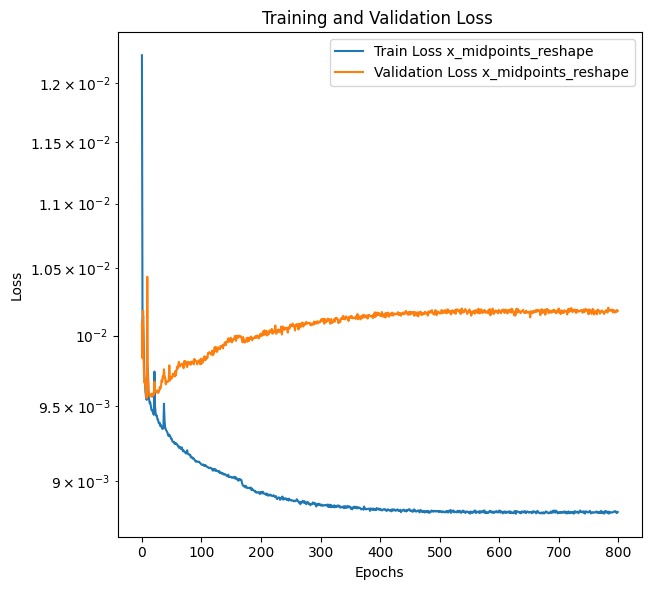

In [17]:


# Extract the losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']


train_loss_x_midpoints = history.history.get('x_midpoints_reshape_loss', train_loss)
val_loss_x_midpoints = history.history.get('val_x_midpoints_reshape_loss', val_loss)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2,1)
plt.plot(train_loss_x_midpoints, label='Train Loss x_midpoints_reshape')
plt.plot(val_loss_x_midpoints, label='Validation Loss x_midpoints_reshape')
plt.xlabel('Epochs')
plt.yscale('log')

plt.ylabel('Loss')
plt.title('Training and Validation Loss ')
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
# loaded_model = tf.keras.models.load_model(
#     "/home/da886/Electron Counting Extended Arch/Weights For Classes/3onlymixed.keras",safe_mode=False,
#     custom_objects={'DynamicExponentCallback': DynamicExponentCallback, 'custom_loss': custom_loss}
# )


/home/da886/anaconda3/envs/objectdetection/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 38 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [20]:
model_builder.model.save('/home/da886/Final Electron counting project/Experimental weights/JoshMSE13fixed.h5')

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the function for visualizing midpoints
def visualize_midpoints(image, midpoints, title="Predicted Midpoint Visualization"):
    """
    Visualizes midpoints on an image without using a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
    - title: The title of the plot.

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    midpoints_np = midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title(title)

    # Plot midpoints directly, only if they are not (0, 0)
    for i, (x, y) in enumerate(midpoints_np):
        if x >= 3 and y >= 3:  # Only plot if the point is not (0, 0)
            plt.scatter(x, y, color='red', s=5)

    plt.show()

# Create the validation dataset
# val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))
# val_dataset = val_dataset.batch(800)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
train_dataset = train_dataset.batch(800)
inputs,targets = next(iter(train_dataset))
outputs = model_builder.model.predict(inputs)
# # Initialize lists to collect the data
# all_images = []
# all_true_midpoints = []
# all_pred_midpoints = []

# # Loop through each batch in the validation dataset, predict, and collect results
# # for i, (data_batch, midpoints_batch) in enumerate(val_dataset):

# for i, (data_batch, midpoints_batch) in enumerate(train_dataset):
#     print(f"Processing batch {i + 1}, batch shape: {data_batch.shape}")
    
#     # Get the model predictions
#     predictions = model_builder.model.predict(data_batch)

#     # Extend the lists to store data from each batch
#     all_images.extend(data_batch.numpy())  # Store all images
#     all_true_midpoints.extend(midpoints_batch.numpy())  # Store all true midpoints
#     all_pred_midpoints.extend(predictions)  # Store all predicted midpoints

# # Convert lists to arrays for easier indexing
# all_images = np.array(all_images)
# all_true_midpoints = np.array(all_true_midpoints)
# all_pred_midpoints = np.array(all_pred_midpoints)


2024-09-23 14:22:11.489887: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
W0000 00:00:1727101331.658713  854852 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727101331.658958  854944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727101331.659958  854852 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727101331.660102  854944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727101331.660471  854852 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727101331.660822  854944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727101331.661320  854852 gpu_timer

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


W0000 00:00:1727101331.691257  854852 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727101331.697953  854852 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727101331.698127  854944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727101331.698450  854852 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727101331.699025  854944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727101331.699227  854852 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727101331.699643  854944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727101331.700158  854852 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727101331.700489  854944 gp

In [33]:
outputs.shape

(800, 1, 13, 2)

In [32]:
targets.shape

TensorShape([800, 1, 13, 2])

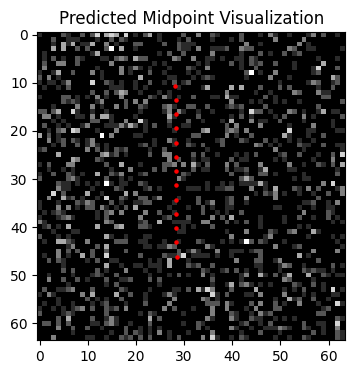

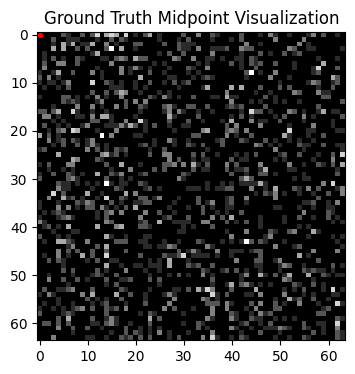

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_midpoints(image, midpoints):
    """
    Visualizes midpoints on an image without using a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    midpoints_np = midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Predicted Midpoint Visualization")

    # Plot midpoints directly
    for i, (x, y) in enumerate(midpoints_np):
        plt.scatter(x, y, color='red', s=5)

    plt.show()

def visualize_midpoints2(image, midpoints):
    """
    Visualizes ground truth midpoints on an image without using a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).

    Returns:
    None (displays the image with midpoints).
    """
    
    image_np = image
    midpoints_np = midpoints
    denormalized_image = image_np 

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Ground Truth Midpoint Visualization")

    # Plot midpoints directly
    for i, (x, y) in enumerate(midpoints_np):
        plt.scatter(x, y, color='red', s=5)

    plt.show()

# Example usage with random data
t = np.random.randint(0, 800)
# t=100

visualize_midpoints(tf.convert_to_tensor(inputs[t]), tf.convert_to_tensor(outputs[t,0,:,:])*64)
visualize_midpoints2(tf.convert_to_tensor(inputs[t]), tf.convert_to_tensor(targets[t,0,:,:])*64)


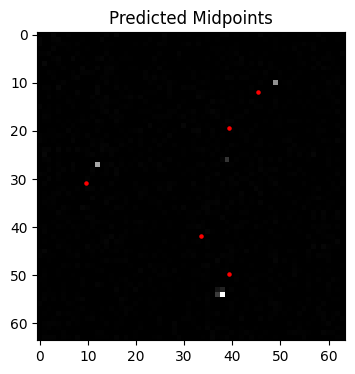

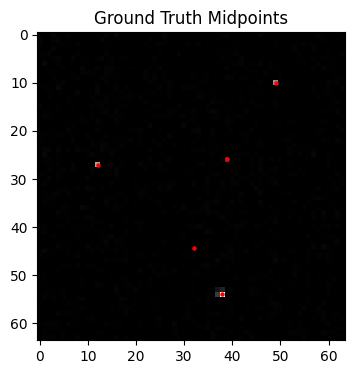

In [25]:

# Select an index to visualize from the entire dataset
index_to_visualize = np.random.randint(0, len(all_images))

# index_to_visualize = 11548
# Visualize the selected image with predicted and true midpoints
visualize_midpoints(all_images[index_to_visualize], all_pred_midpoints[index_to_visualize, 0, :, :] * 64, title="Predicted Midpoints")
visualize_midpoints(all_images[index_to_visualize], all_true_midpoints[index_to_visualize, 0, :, :] * 64, title="Ground Truth Midpoints")


code to visualize Josh's edit

In [45]:
# model_builder.model.save('/home/da886/Electron Counting Extended Arch/Overfitted weights/increased_model_Padded_weights.keras')

In [268]:
val_loss = model_builder.model.evaluate(val_dataset)

30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - loss: 0.0136


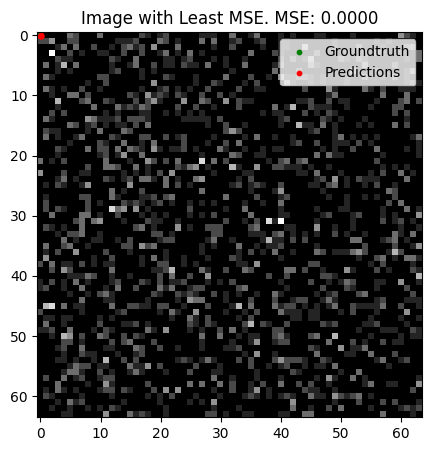

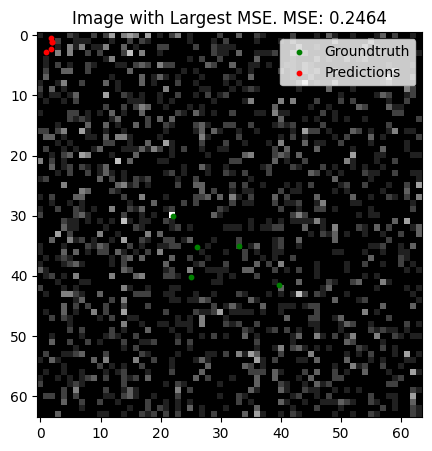

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize variables to track the min and max MSE
min_mse = float('inf')
max_mse = float('-inf')
min_mse_index = -1
max_mse_index = -1

# Loop through each prediction to calculate the MSE
for i in range(len(all_pred_midpoints)):
    mse = np.mean((all_pred_midpoints[i] - all_true_midpoints[i]) ** 2)
    
    if mse < min_mse:
        min_mse = mse
        min_mse_index = i
    
    if mse > max_mse:
        max_mse = mse
        max_mse_index = i
import numpy as np
import matplotlib.pyplot as plt

# Function to plot an image with its centers
def plot_image_with_centers(image, true_center, predicted_center, title):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.squeeze(), cmap='gray')  # Display the image

    # Plot the actual center (Groundtruth)
    plt.scatter(true_center[:, 0], true_center[:, 1], color='green', label='Groundtruth', s=10)

    # Plot the predicted center
    plt.scatter(predicted_center[:, 0], predicted_center[:, 1], color='red', label='Predictions', s=10)

    plt.title(title)
    plt.legend()
    plt.show()






# Plotting the image with the least MSE
plot_image_with_centers(all_images[min_mse_index],
                        all_true_midpoints[min_mse_index][0] * 64,  # Adjust for scaling if needed
                        all_pred_midpoints[min_mse_index][0] * 64,  # Adjust for scaling if needed
                        f'Image with Least MSE. MSE: {min_mse:.4f}')

# Plotting the image with the largest MSE
plot_image_with_centers(all_images[max_mse_index],
                        all_true_midpoints[max_mse_index][0] * 64,  # Adjust for scaling if needed
                        all_pred_midpoints[max_mse_index][0] * 64,  # Adjust for scaling if needed
                        f'Image with Largest MSE. MSE: {max_mse:.4f}')




In [263]:
max_mse_index

11548